# Land Accounts inference on Sentinel-2 GeoMAD with Random Forest

This workflow demonstrates how to use a
[Sentinel-2](https://www.esa.int/Applications/Observing_the_Earth/Copernicus/Sentinel-2)
[GeoMedian annual satellite imagery composite](https://github.com/digitalearthpacific/dep-geomad)
for segmenting land use / land cover (LULC) using a
[GPU-accelerated Random Forest classifier](https://developer.nvidia.com/blog/accelerating-random-forests-up-to-45x-using-cuml/).
To make this scalable to all of Vanuatu, we use an
[administrative boundaries dataset from Pacific data hub](https://pacificdata.org/data/dataset/2016_vut_phc_admin_boundaries/resource/66ae054b-9b67-4876-b59c-0b078c31e800).

In this notebook, we will demonstrate the following:

1. **Data Acquisition**:
   - We use **Sentinel-2 L2A** data accessed via the [Digital Earth Pacific STAC catalog](http://stac.digitalearthpacific.org/). The search is filtered by parameters like a region of interest (AOI) and time range to obtain suitable imagery.

2. **Preprocessing**:
   - The Sentinel-2 imagery contains several spectral bands (e.g., Red, Green, Blue, Near-Infrared, Short-wave Infrared). These are extracted and combined into a single dataset for analysis. Remote sensing indices useful for land use / land cover mapping are calculated from these bands. Additionally, the imagery is masked to remove areas outside the regions of interest so as to focus on the relevant pixels.

3. **Feature Extraction**:
   - Features for the classifier are extracted from the Sentinel-2 spectral bands. Here, we will use the reflectance values from the Red, Green, Blue, Near-Infrared (NIR), and Short-wave Infrared (SWIR) bands. We will compute remote sensing indices (NDVI, MNDWI, SAVI, BSI, NDBI) from these bands as the final feature set.

4. **Prediction**:
   - We will use the trained classifier to predict the likelihood of lulc types for each pixel in the image/province.

5. **Visualization**:
   - We visualize the predictions by plotting the classified map, where lulc types are indicated by specific color codes.

6. **Post-processing**:
   - We will use a sieve filter to "smooth" the predictions and dissolve isolated pixels.

7. **Vectorize**:
   - Finally, we'll convert our LULC into polygons and save to a GeoJSON file.

In [1]:
!mamba install --channel rapidsai --quiet --yes cuml

Preparing transaction: ...working... done
Verifying transaction: ...working... done
Executing transaction: ...working... 
To enable CUDA support, UCX requires the CUDA Runtime library (libcudart).
The library can be installed with the appropriate command below:

* For CUDA 11, run:    conda install cudatoolkit cuda-version=11
* For CUDA 12, run:    conda install cuda-cudart cuda-version=12

If any of the packages you requested use CUDA then CUDA should already
have been installed for you.


done


In [2]:
import geopandas as gpd
import pickle
import hvplot.xarray
import matplotlib.pyplot as plt
import numpy as np
import odc.stac
import rasterio.features
from rasterio.features import sieve
import rioxarray
import xarray as xr
# from cuml import RandomForestClassifier
from pystac_client import Client
from shapely.geometry import box, mapping, shape

## Data Acquisition

Let's read the LULC data into a GeoDataFrame.

A [GeoDataFrame](https://geopandas.org/en/stable/docs/reference/geodataframe.html) is a type of data structure used to store geographic data in Python, provided by the [GeoPandas](https://geopandas.org/en/stable/) library. It extends the functionality of a pandas DataFrame to handle spatial data, enabling geospatial analysis and visualization. Like a pandas DataFrame, a GeoDataFrame is a tabular data structure with labeled axes (rows and columns), but it adds special features to work with geometric objects, such as:
- a geometry column
- a CRS
- accessibility to spatial operations (e.g.  intersection, union, buffering, and spatial joins)

In [3]:
# Version of the LULC model (based on, for example, ROIs_v9.zip)
ROI_VERSION = "9"
YEAR = 2020  # year to run inference on
PROVINCE_INFERENCE = "SHEFA"  # Vanuatu province, choose from ["TORBA", "SANMA", "PENAMA", "MALAMPA", "TAFEA"]

In [4]:
# Download the administrative boundaries (2016_phc_vut_pid_4326.geojson)
!wget https://pacificdata.org/data/dataset/9dba1377-740c-429e-92ce-6a484657b4d9/resource/3d490d87-99c0-47fd-98bd-211adaf44f71/download/2016_phc_vut_pid_4326.geojson

--2025-08-18 19:49:42--  https://pacificdata.org/data/dataset/9dba1377-740c-429e-92ce-6a484657b4d9/resource/3d490d87-99c0-47fd-98bd-211adaf44f71/download/2016_phc_vut_pid_4326.geojson
Resolving pacificdata.org (pacificdata.org)... 172.66.159.122, 104.20.22.47, 2606:4700:10::6814:162f, ...
Connecting to pacificdata.org (pacificdata.org)|172.66.159.122|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3102682 (3.0M) [application/json]
Saving to: ‘2016_phc_vut_pid_4326.geojson.1’

2016_phc_vut_pid_43 100%[===================>]   2.96M  1.69MB/s    in 1.7s    

2025-08-18 19:49:46 (1.69 MB/s) - ‘2016_phc_vut_pid_4326.geojson.1’ saved [3102682/3102682]



Read and inspect the datasets.

In [5]:
lulc_gdf = gpd.read_file(f"./ROIs_v{ROI_VERSION}.zip")

In [6]:
admin_boundaries_gdf = gpd.read_file("./2016_phc_vut_pid_4326.geojson")

In [7]:
admin_boundaries_gdf

,pid,pname,geometry
0,1,TORBA,"MULTIPOLYGON (((168.03896 -14.48033, 168.03885..."
1,2,SANMA,"MULTIPOLYGON (((167.25572 -15.71481, 167.25582..."
2,3,PENAMA,"MULTIPOLYGON (((168.2481 -15.78748, 168.24811 ..."
3,4,MALAMPA,"MULTIPOLYGON (((167.48039 -16.60241, 167.47951..."
4,5,SHEFA,"MULTIPOLYGON (((168.30762 -17.77548, 168.30773..."
5,6,TAFEA,"MULTIPOLYGON (((169.84994 -20.25396, 169.85015..."


Create a raster image xarray datarray.

In [8]:
if not admin_boundaries_gdf.index.name == "pname":
    admin_boundaries_gdf = admin_boundaries_gdf.set_index(
        keys="pname"  # set province name as the index
    )

In [9]:
admin_boundaries_gdf

,pid,geometry
pname,,
TORBA,1,"MULTIPOLYGON (((168.03896 -14.48033, 168.03885..."
SANMA,2,"MULTIPOLYGON (((167.25572 -15.71481, 167.25582..."
PENAMA,3,"MULTIPOLYGON (((168.2481 -15.78748, 168.24811 ..."
MALAMPA,4,"MULTIPOLYGON (((167.48039 -16.60241, 167.47951..."
SHEFA,5,"MULTIPOLYGON (((168.30762 -17.77548, 168.30773..."
TAFEA,6,"MULTIPOLYGON (((169.84994 -20.25396, 169.85015..."


Get geometries of one province.

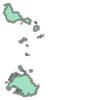

In [10]:
GEOM_INFERENCE = admin_boundaries_gdf.loc[PROVINCE_INFERENCE].geometry
GEOM_INFERENCE

Make numerical class IDs and get a subsetted ROIs dataframe just for the inference province.

In [11]:
unique_classes = lulc_gdf["ROI"].unique()
# class_mapping = {cls: i+1 for i, cls in enumerate(unique_classes)}
class_mapping = {
    cls: i for i, cls in enumerate(unique_classes)
}  # zero-based, assumes existence of no data
print(class_mapping)

{'Water Bodies': 0, 'Coconut Plantations': 1, 'Grassland': 2, 'Mangroves': 3, 'Agriculture': 4, 'Barelands': 5, 'Builtup Infrastructure': 6, 'Dense_Forest': 7, 'Open_Forest': 8}


In [12]:
gdf_inference = lulc_gdf.query(expr=f"Pname == '{PROVINCE_INFERENCE}'")

Get Sentinel-2 GeoMedian composite data for selected year for one province

In [13]:
STAC_URL = "http://stac.digitalearthpacific.org/"
stac_client = Client.open(STAC_URL)

In [14]:
s2_search = stac_client.search(
    collections=["dep_s2_geomad"],
    intersects=GEOM_INFERENCE,
    datetime=str(YEAR),
)
# Retrieve all items from search results
s2_items = s2_search.item_collection()
print("len(s2_items): ", len(s2_items))

s2_data_inference = odc.stac.load(
    items=s2_items,
    bands=["blue", "green", "red", "nir08", "swir16"],
    chunks={"x": 1024, "y": 1024, "bands": -1, "time": -1},
    crs="EPSG:32759",
    resolution=20,
)
s2_data_inference

len(s2_items):  3


<xarray.Dataset> Size: 661MB
Dimensions:      (y: 13828, x: 4779, time: 1)
Coordinates:
  * y            (y) float64 111kB 8.231e+06 8.231e+06 ... 7.954e+06 7.954e+06
  * x            (x) float64 38kB 1.676e+05 1.676e+05 ... 2.631e+05 2.631e+05
    spatial_ref  int32 4B 32759
  * time         (time) datetime64[ns] 8B 2020-01-01
Data variables:
    blue         (time, y, x) uint16 132MB dask.array<chunksize=(1, 1024, 1024), meta=np.ndarray>
    green        (time, y, x) uint16 132MB dask.array<chunksize=(1, 1024, 1024), meta=np.ndarray>
    red          (time, y, x) uint16 132MB dask.array<chunksize=(1, 1024, 1024), meta=np.ndarray>
    nir08        (time, y, x) uint16 132MB dask.array<chunksize=(1, 1024, 1024), meta=np.ndarray>
    swir16       (time, y, x) uint16 132MB dask.array<chunksize=(1, 1024, 1024), meta=np.ndarray>

Buffer the geometries to include some coastal offshore areas to account for any
classes/ROIs that might be relevant and overlapping.

In [ ]:
# Keep projection aligned with raster
raster_crs = s2_data_inference.rio.crs
print(raster_crs)

# Get only the select province and reproject
admin_boundaries_reprojected_inference = admin_boundaries_gdf.loc[[PROVINCE_INFERENCE]].to_crs(
    crs=raster_crs
)

# Buffer in raster units (meters if UTM)
geom_buffered_inference = admin_boundaries_reprojected_inference.buffer(distance=5)[PROVINCE_INFERENCE]
geom_buffered_inference

Clip the Sentinel-2 data to be within the buffered geometries only.

In [16]:
# Clip inference province
s2_clipped_inference = s2_data_inference.rio.clip(geometries=[geom_buffered_inference])

In [17]:
# Plot inference province
s2_rgb = s2_clipped_inference[["red", "green", "blue"]]
s2_rgb_array = s2_rgb.to_array("band")  # now dims: band, y, x
s2_rgb_array_squeezed = s2_rgb_array.squeeze(dim="time", drop=True)

In [ ]:
s2_rgb_array_squeezed.plot.imshow(size=4, vmin=0, vmax=3000)

Calculate remote sensing indices.

In [19]:
# Calculate remote sensing indices useful for mapping LULC
def compute_indices(ds):
    red = ds["red"]
    green = ds["green"]
    blue = ds["blue"]
    nir = ds["nir08"]
    swir = ds["swir16"]
    eps = 1e-6
    return xr.Dataset({
        "NDVI": (nir - red) / (nir + red + eps),
        "MNDWI": (green - swir) / (green + swir + eps),
        "SAVI": ((nir - red) / (nir + red + 0.5 + eps)) * 1.5,
        "BSI": ((swir + red) - (nir + blue)) / ((swir + red) + (nir + blue) + eps),
        "NDBI": (swir - nir) / (swir + nir + eps),
    })


index_data_inference = compute_indices(s2_clipped_inference).squeeze("time", drop=True)
print(index_data_inference)

<xarray.Dataset> Size: 796MB
Dimensions:      (y: 6968, x: 2856)
Coordinates:
  * y            (y) float64 56kB 8.166e+06 8.166e+06 ... 8.027e+06 8.027e+06
  * x            (x) float64 23kB 1.926e+05 1.926e+05 ... 2.497e+05 2.497e+05
    spatial_ref  int64 8B 0
Data variables:
    NDVI         (y, x) float64 159MB dask.array<chunksize=(885, 797), meta=np.ndarray>
    MNDWI        (y, x) float64 159MB dask.array<chunksize=(885, 797), meta=np.ndarray>
    SAVI         (y, x) float64 159MB dask.array<chunksize=(885, 797), meta=np.ndarray>
    BSI          (y, x) float64 159MB dask.array<chunksize=(885, 797), meta=np.ndarray>
    NDBI         (y, x) float64 159MB dask.array<chunksize=(885, 797), meta=np.ndarray>


In [20]:
width_inference, height_inference = s2_clipped_inference.x.size, s2_clipped_inference.y.size
gdf_inference = gdf_inference.to_crs(epsg=s2_clipped_inference.rio.crs.to_epsg())

Flatten pixels and only retain the those that overlap with an ROI.
The labels (ROIs) are sparse, so we will throw out pixels in regions between ROIs (unlabeled).

In [21]:
features_inference = index_data_inference.to_array().stack(flattened_pixel=("y", "x"))

features_inference = features_inference[:].transpose("flattened_pixel", "variable").compute()

print("features_inference shape:", features_inference.shape)

features_inference shape: (19900608, 5)


In [22]:
len(features_inference)

19900608

## Random Forest Classification

Now we will load a trained [random forest classifier](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html).

In [23]:
%%time
# Load trained Random Forest classifier
clf = pickle.load(open(f"rf_vanuatu_lulc_{YEAR}_ROIversion{ROI_VERSION}.pkl", "rb"))

CPU times: user 752 ms, sys: 403 ms, total: 1.16 s
Wall time: 1.47 s


## Inference

Once the trained classifier has been loaded, we can use it to make predictions on one province.

In [24]:
y_pred = clf.predict(features_inference)

As a reminder, these are what each class number represents.

In [25]:
print("Class mapping:")
for key, val in class_mapping.items():
    print(val, key)

Class mapping:
0 Water Bodies
1 Coconut Plantations
2 Grassland
3 Mangroves
4 Agriculture
5 Barelands
6 Builtup Infrastructure
7 Dense_Forest
8 Open_Forest


## Visualization

In [26]:
predicted_map = y_pred.reshape((height_inference, width_inference))
predicted_map.shape

(6968, 2856)

In [27]:
predicted_map_xr = xr.DataArray(
    data=predicted_map,
    coords=s2_clipped_inference.squeeze("time", drop=True).coords,
)
print(np.unique(y_pred))

[0 1 2 3 4 5 6 7 8]


In [28]:
predicted_map_xr

<xarray.DataArray (y: 6968, x: 2856)> Size: 159MB
array([[3, 3, 3, ..., 3, 3, 3],
       [3, 3, 3, ..., 3, 3, 3],
       [3, 3, 3, ..., 3, 3, 3],
       ...,
       [3, 3, 3, ..., 3, 3, 3],
       [3, 3, 3, ..., 3, 3, 3],
       [3, 3, 3, ..., 3, 3, 3]])
Coordinates:
  * y            (y) float64 56kB 8.166e+06 8.166e+06 ... 8.027e+06 8.027e+06
  * x            (x) float64 23kB 1.926e+05 1.926e+05 ... 2.497e+05 2.497e+05
    spatial_ref  int64 8B 0

In [29]:
predicted_map_xr.rio.crs

CRS.from_wkt('PROJCS["WGS 84 / UTM zone 59S",GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563]],PRIMEM["Greenwich",0],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AUTHORITY["EPSG","4326"]],PROJECTION["Transverse_Mercator"],PARAMETER["latitude_of_origin",0],PARAMETER["central_meridian",171],PARAMETER["scale_factor",0.9996],PARAMETER["false_easting",500000],PARAMETER["false_northing",10000000],UNIT["metre",1],AXIS["Easting",EAST],AXIS["Northing",NORTH],AUTHORITY["EPSG","32759"]]')

In [30]:
predicted_map_xr = predicted_map_xr.rio.clip(
    geometries=[geom_buffered_inference],
    crs=predicted_map_xr.rio.crs,
    drop=True
)

# Convert sentinel int value to NaN
predicted_map_xr = predicted_map_xr.where(predicted_map_xr != np.iinfo(predicted_map_xr.dtype).min)

In [31]:
np.unique(predicted_map_xr.values)

array([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8., nan])

In [ ]:
predicted_map_xr.hvplot.image(height=600, rasterize=True, cmap="Set1")

In [32]:
predicted_map_xr

<xarray.DataArray (y: 6968, x: 2856)> Size: 159MB
array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]])
Coordinates:
  * y            (y) float64 56kB 8.166e+06 8.166e+06 ... 8.027e+06 8.027e+06
  * x            (x) float64 23kB 1.926e+05 1.926e+05 ... 2.497e+05 2.497e+05
    spatial_ref  int64 8B 0

### Post-processing
We will use a sieve filter to remove small isolated pixels from the LULC result.

In [ ]:
def sieve_xarray_with_nodata(da, size=3):
    """
    Apply rasterio sieve to an xarray.DataArray with integer classes,
    remove small clumps, and set masked areas to NaN.
    """
    arr = da.values.copy()
    
    # Temporarily replace NaNs with a float value
    sentinel = -9999
    arr_filled = np.where(np.isnan(arr), sentinel, arr).astype(np.int32)
    
    # Apply sieve
    sieved = sieve(arr_filled, size=size, connectivity=8)
    
    # Convert to float before assigning NaN
    sieved = sieved.astype("float32")
    
    # Restore NaN for previously masked pixels
    sieved[sieved == sentinel] = np.nan
    
    return xr.DataArray(
        sieved,
        coords=da.coords,
        dims=da.dims,
        attrs=da.attrs
    )

lulc_smoothed = sieve_xarray_with_nodata(predicted_map_xr, size=3) # increase size to intensify smoothing

# Check unique values (ignoring NaNs)
print(np.unique(lulc_smoothed.values[~np.isnan(lulc_smoothed.values)]))

In [ ]:
lulc_smoothed.hvplot.image(height=600, rasterize=True, cmap="Set1")

### Vectorize

In [55]:
compatible_array = lulc_smoothed.astype("float32") #predicted_map_xr.astype("float32")
mask = ~np.isnan(compatible_array.values)  # mask valid values

# Rasterize to polygons
polygons = list(
    rasterio.features.shapes(
        compatible_array.values, transform=compatible_array.rio.transform(),
        mask=mask,
    )
)

# Convert polygons to GeoDataFrame and filter out masked value
prediction_gdf = gpd.GeoDataFrame(
    [{"geometry": shape(geom), "value": int(value)} for geom, value in polygons if not np.isnan(value)],
    crs=predicted_map_xr.rio.crs  # keep raster CRS
)

# print(prediction_gdf)
print(prediction_gdf.value.unique())

prediction_gdf.to_file(
    f"./predicted_lulc_utm_{PROVINCE_INFERENCE}_{YEAR}_ROIv{ROI_VERSION}_smoothed.geojson", driver="GeoJSON"
)

[5 1 3 4 7 0 8 2 6]


In [61]:
prediction_gdf.head(10)

,geometry,value
0,"POLYGON ((199380 8166480, 199380 8166460, 1994...",0
1,"POLYGON ((199420 8166480, 199420 8166460, 1994...",5
2,"POLYGON ((199300 8166460, 199300 8166440, 1993...",5
3,"POLYGON ((199320 8166460, 199320 8166440, 1993...",4
4,"POLYGON ((199340 8166460, 199340 8166440, 1993...",7
5,"POLYGON ((199380 8166460, 199380 8166440, 1994...",7
6,"POLYGON ((199440 8166460, 199440 8166440, 1994...",1
7,"POLYGON ((199460 8166460, 199460 8166440, 1994...",5
8,"POLYGON ((199240 8166440, 199240 8166420, 1992...",5
9,"POLYGON ((199260 8166440, 199260 8166420, 1993...",0


You can run these predictions on every province, collect the geodataframes in a list, and combine them into a final, unified nationwide LULC vector dataset like so (placeholder code, you need to generate the predictions first):

In [ ]:
# prediction_gdf_merged_nationwide = pd.concat(
#     [
#         prediction_gdf_TORBA,
#         prediction_gdf_SANMA,
#         prediction_gdf_PENAMA,
#         prediction_gdf_MALAMPA,
#         prediction_gdf_SHEFA,
#         prediction_gdf_TAFEA,
#     ],
#     ignore_index=True,
# )
#
# prediction_gdf_merged_nationwide.to_file(
#     f"./predicted_lulc_utm_nationwide_{YEAR}_ROIv{ROI_VERSION}.geojson", driver="GeoJSON"
# )